# Getting gene ontology information from gene list
Takes a txt file saved from the Klein RNAseq data website www.tinyurl.com/scZfish2018 (remove first two rows), and gets info from Biomart (full name, GO terms, human orthologs).
Saves an enriched list, and a list of genes that were not found in Biomart (the Klein names are ZV10, biomart is using ZV11).
Provides gene ontology information.

In [1]:
#Input the path to the folder containing the file
path='C:/Users/Florence/OneDrive - King\'s College London/Single cell RNAseq/Wagner dataset/Data/Forebrain1/ET_ant_vs_tel.txt'

#Input the path to the file containing z10 to z11 conversion names
path2='C:/Users/Florence/OneDrive - King\'s College London/Single cell RNAseq/Wagner dataset/Code/z10-z11.csv'

In [2]:
from biomart import BiomartServer
import pandas as pd
import os
from matplotlib import pyplot as plt
from goatools import obo_parser

Read the gene list from the txt file. Text file downloaded from the Klein website. Remove the first two lines, to keep only the header and gene list.
Only the first 500 rows are taken, otherwise biomart may throw an error, saying the query is too long.

In [3]:
geneset=pd.read_csv(path, sep='\t', names=['external_gene_name','Z_score'])
geneset['external_gene_name_lower'] = geneset['external_gene_name'].str.lower()
geneset.head()

,external_gene_name,Z_score,external_gene_name_lower
0,rx3,1.037,rx3
1,cdh2,1.018,cdh2
2,nr2f5,0.960,nr2f5
3,clic4,0.923,clic4
4,flrt3,0.919,flrt3


Load the z10 to z11 file, and use to replace z10 names by z11 names (the Klein names are ZV10, biomart is using ZV11).

In [4]:
dico=pd.read_csv(path2, sep=';')
geneset=geneset.replace(dico['z10'].tolist(),dico['z11'].tolist())

In [5]:
server = BiomartServer( "http://www.ensembl.org/biomart" )
server.verbose = False
drerio=server.datasets['drerio_gene_ensembl']

Get gene name, gene description, go terms and ZFIN ID

In [6]:
gene_list=geneset[:500]['external_gene_name'].tolist()
response = drerio.search({
  'filters': {
      'external_gene_name': gene_list
  },
  'attributes': [
      'ensembl_gene_id', 'external_gene_name', 'description','name_1006','go_id','zfin_id_id'
  ]
})


with open('csvfile.csv','w') as file:
    line='ensembl_gene_id\texternal_gene_name\tdescription\tname_1006\tgo_id\tzfin_id_id'
    file.write(line)
    file.write('\n')
    for line in response.iter_lines():
        line = line.decode('utf-8')
        file.write(line)
        file.write('\n')

df=pd.read_csv('csvfile.csv', sep='\t')
os.remove('csvfile.csv')

Identify genes that were discarded to manually add them to the z10 -> z11 table, and re-run 3 cells above

In [7]:
subset=geneset[:500]
df['external_gene_name_lower'] = df['external_gene_name'].str.lower()
discarded=subset.merge(df, on='external_gene_name_lower', indicator=True, how="left")[lambda x: x._merge=='left_only'].drop('_merge',1)
discarded=discarded[['external_gene_name_x', 'Z_score']]
discarded.to_excel(os.path.dirname(path)+'/gene_discarded.xls')

Remove non necessary columns for further GO analysis

In [8]:
df1=df[['external_gene_name', 'go_id']]

Gene ontology

In [9]:
go = obo_parser.GODag("go-basic.obo")

go-basic.obo: fmt(1.2) rel(2020-03-23) 47,232 GO Terms


Gene ontology terms are classified in three branches or "spaces": molecular function, cellular component and biological process. They are classified in a hierarchical manner, with a certain level.

In [10]:
df1=df1.dropna()
df1=df1.reset_index()
df1['go_level']=df1['go_id']
df1['name_space']=df1['go_id']

for i in df1.index:
    df1['go_level'][i]=go[df1['go_id'][i]].level
    df1['name_space'][i]=go[df1['go_id'][i]].namespace
    
df1.head()

C:\Users\Florence\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\Users\Florence\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,index,external_gene_name,go_id,go_level,name_space
0,0,ankhd1,GO:0005737,2,cellular_component
1,1,ankhd1,GO:0003676,3,molecular_function
2,2,ankhd1,GO:0003723,4,molecular_function
3,3,ankhd1,GO:0060047,5,biological_process
4,4,ankhd1,GO:0045087,3,biological_process


In [11]:
df_mol=df1[df1['name_space']=='molecular_function']
df_cell=df1[df1['name_space']=='cellular_component']
df_bio=df1[df1['name_space']=='biological_process']

In [12]:
def level_go(go_id,lev):
    '''returs go_id parents of level lev'''
    go_term=go[go_id]
    GO=list()
    levelgo=list()
    parents=go_term.get_all_parents()
    
    for i in parents:
        GO.append(i)
        levelgo.append(go[i].level)
        
    parents_df=pd.DataFrame()
    parents_df['id']=GO
    parents_df['level']=levelgo

    #for each set of GO, extracts those of lev level
    dleveled=parents_df[parents_df['level']==lev]
    GO_leveled=dleveled['id']
    return list(GO_leveled)

In [13]:
def gene_level_go (df,gene,lev=2):
    '''gets all go id of level lev or below for a single gene'''
    d_gene=df[df['external_gene_name']==gene]
    go_gene_leveled=[]
    for i in d_gene.index:
        if d_gene['go_level'][i]>lev:
            golist=level_go(d_gene['go_id'][i],lev)
        else:
            golist=[d_gene['go_id'][i]]
        go_gene_leveled+=golist
        
    go_gene_leveled=list(set(go_gene_leveled))
    
    return go_gene_leveled


def gene_level_go_groupby(df, lev):
    '''combine with groupy to get all go id of level lev or below for all genes'''
    go_gene_leveled=[]
    for i in df.index:
        if df['go_level'][i]>lev:
            golist=level_go(df['go_id'][i],lev)
        else:
            golist=[df['go_id'][i]]
        go_gene_leveled+=golist
        
    go_gene_leveled=list(set(go_gene_leveled))
    
    return go_gene_leveled


def gene_level_go_V3(d_gene, lev = 2):
    '''combine with groupy to get all go id of level lev or below for all genes'''
    go_gene_leveled=[]
    for i in d_gene.index:
        if d_gene['go_level'][i]>2:
            golist=level_go(d_gene['go_id'][i],lev)
        else:
            golist=[d_gene['go_id'][i]]
        go_gene_leveled+=golist
    go_gene_leveled=list(set(go_gene_leveled))
    return go_gene_leveled

In [14]:
#je veux level 0 pour tous sauf cytoskeleton organisation:'GO:0030865' et extracellular matrix organization:'GO:0030198'

#ramener tout le monde à level 5

#def gene_level_go_groupby(df, lev):
    #'''combine with groupy to get all go id of level lev or below for all genes'''
    #go_gene_leveled=[]
    #for i in df.index:
        #if df['go_level'][i]>lev:
            #golist=level_go(df['go_id'][i],lev)
       # else:
            #golist=[df['go_id'][i]]
        #go_gene_leveled+=golist
        
   # go_gene_leveled=list(set(go_gene_leveled))
    
    #return go_gene_leveled


#s=df_bio.groupby('external_gene_name').apply(gene_level_go_groupby_BBSRC,5)
#df2_level5=pd.DataFrame({'external_gene_name':s.index, 'GO_id':s.values})
#df2_level5.head()

In [15]:
#on sort

#mylist = ['GO:0007010', 'GO:0030198','GO:0007015','GO:0030334','GO:0032956']
#pattern = '|'.join(mylist)
#pattern
#exception=df2_level5.GO_id.astype('str').str.contains(pattern)
#df2_ECM_cyto=df2_level5[exception]
#df2_ECM_cyto['GO_id']
#df2_les_autres=df2_level5[~exception]
#df2_ECM_cyto.head()

In [16]:
# on applique avec level 1

s=df1.groupby('external_gene_name').apply(gene_level_go_groupby,1)
df2=pd.DataFrame({'external_gene_name':s.index, 'GO_id':s.values})
df2.head()

,external_gene_name,GO_id
0,CAMSAP3,"[GO:0005488, GO:0065007, GO:0009987, GO:0110165]"
1,DXO,"[GO:0008152, GO:0110165, GO:0009987, GO:006500..."
2,FAM53C,"[GO:0051179, GO:0009987, GO:0110165]"
3,FOXK2,"[GO:0005488, GO:0065007, GO:0140110, GO:0110165]"
4,MYG1,"[GO:0003674, GO:0110165, GO:0008150]"


In [17]:
#on rajoute les termes level5 a level2
#df3=df2_level1
#for i in df2_ECM_cyto.index:
    #df3['GO_id'][df3['external_gene_name']==df2_ECM_cyto['external_gene_name'][i]]+=df2_ECM_cyto['GO_id'][i]

On rajoute les noms des GO

In [18]:
df4=df2
df4['GO_name']=df2['GO_id']
for i in df2.index:
    df4['GO_name'][i]=[]
    for j in df2['GO_id'][i]:
        df4['GO_name'][i].append(go[j].name)
        
df4.head()

,external_gene_name,GO_id,GO_name
0,CAMSAP3,"[GO:0005488, GO:0065007, GO:0009987, GO:0110165]","[binding, biological regulation, cellular proc..."
1,DXO,"[GO:0008152, GO:0110165, GO:0009987, GO:006500...","[metabolic process, cellular anatomical entity..."
2,FAM53C,"[GO:0051179, GO:0009987, GO:0110165]","[localization, cellular process, cellular anat..."
3,FOXK2,"[GO:0005488, GO:0065007, GO:0140110, GO:0110165]","[binding, biological regulation, transcription..."
4,MYG1,"[GO:0003674, GO:0110165, GO:0008150]","[molecular_function, cellular anatomical entit..."


Merge to original gene set, to reinclude scores. Order on score. Save.

In [19]:
df4=pd.merge(df4,geneset, on='external_gene_name')

df4=df4.sort_values(by=['Z_score'],ascending=False)
df4=df4[['external_gene_name','Z_score','GO_name','GO_id']]
df4.to_excel(os.path.dirname(path)+'/gene_list.xlsx')
df4.head()

,external_gene_name,Z_score,GO_name,GO_id
281,rx3,1.037,"[cellular anatomical entity, binding, biologic...","[GO:0110165, GO:0005488, GO:0065007, GO:014011..."
38,cdh2,1.018,"[cellular anatomical entity, binding, cellular...","[GO:0110165, GO:0005488, GO:0009987, GO:006500..."
206,nr2f5,0.960,"[response to stimulus, cellular anatomical ent...","[GO:0050896, GO:0110165, GO:0060089, GO:000548..."
48,clic4,0.923,"[cellular anatomical entity, binding, transpor...","[GO:0110165, GO:0005488, GO:0005215, GO:000998..."
101,flrt3,0.919,"[binding, cellular anatomical entity]","[GO:0005488, GO:0110165]"


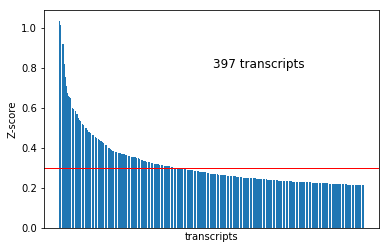

In [20]:
number_transcripts=df4.shape[0]
t=str(number_transcripts)+' transcripts'
Z_threshold=0.3
plt.bar(df4['external_gene_name'],df4['Z_score'])
plt.ylabel('Z-score')
plt.xlabel('transcripts')
plt.xticks([])
plt.axhline(y=Z_threshold,linewidth=1, color='r')
#plt.xticks(rotation=90)
plt.text(200, 0.8, t, fontsize=12)
plt.show()

Filter on Z_score

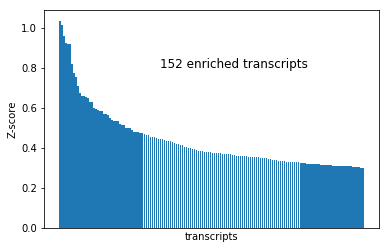

In [21]:
df5=df4[df4['Z_score']>Z_threshold]
selected=df5.shape[0]
t1=str(selected)+' enriched transcripts'
#plt.figure(figsize=[20, 4.8])
plt.bar(df5['external_gene_name'],df5['Z_score'])
plt.ylabel('Z-score')
plt.xlabel('transcripts')
plt.xticks([])
plt.xticks(rotation=90)
plt.text(50, 0.8, t1, fontsize=12)
plt.show()

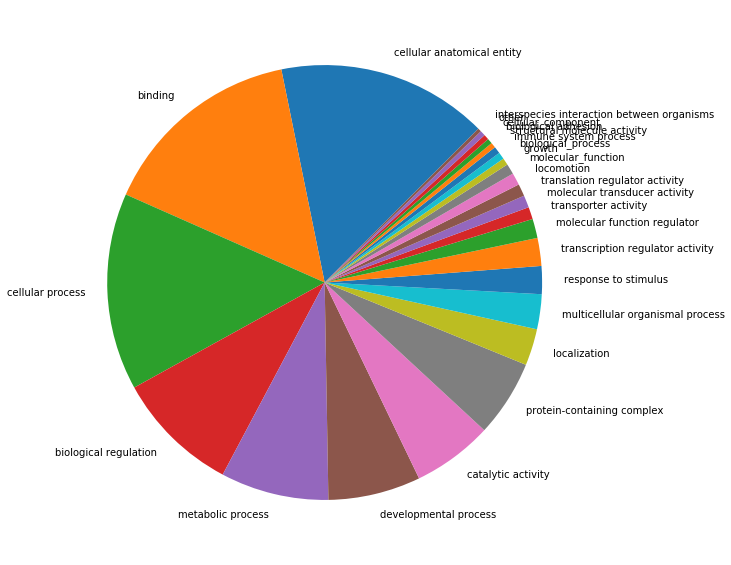

{'cellular anatomical entity': 121, 'binding': 117, 'biological regulation': 71, 'transcription regulator activity': 16, 'developmental process': 53, 'multicellular organismal process': 20, 'cellular process': 113, 'biological adhesion': 3, 'response to stimulus': 16, 'molecular transducer activity': 7, 'transporter activity': 7, 'localization': 21, 'protein-containing complex': 44, 'immune system process': 4, 'locomotion': 7, 'metabolic process': 62, 'catalytic activity': 46, 'molecular function regulator': 11, 'biomineralization': 1, 'interspecies interaction between organisms': 2, 'growth': 4, 'translation regulator activity': 7, 'structural molecule activity': 3, 'protein folding chaperone': 1, 'molecular_function': 6, 'cellular_component': 3, 'biological_process': 4, 'behavior': 1}


In [22]:
df_GO=df5['GO_name']
GO = dict()
for i in df_GO :
        for j in i :
                if j in GO.keys():
                    GO[j]+=1
                else :
                    GO[j]=1

GO_thres={'other':0}
threshold=1
for key,value in GO.items():
    if value<=threshold:
        GO_thres['other']+=value
    else:
        GO_thres[key]=value
#GO_thres['biological_process']=0

GO_thres_df=pd.DataFrame(list(GO_thres.items()))
GO_thres_df.columns=['GO','number']
GO_thres_df=GO_thres_df[GO_thres_df['number']>0]
GO_thres_df=GO_thres_df.sort_values(by=['number'], ascending=False)
plt.figure(figsize=[40,10])
plt.pie(GO_thres_df.number,labels=GO_thres_df.GO,startangle=45)
plt.show()
print(GO)

#parents=go['GO:0030865'].get_all_parents()
#GO=list()
#levelgo=list()
#name=list()
#for i in parents:
        GO.append(i)
        levelgo.append(go[i].level)
        name.append(go[i].name)
        
parents_df=pd.DataFrame()
parents_df['id']=GO
parents_df['level']=levelgo
parents_df['name']=name
print(go['GO:0030865'].id+' '+go['GO:0030865'].name)
print(parents_df)

parents=go['GO:0030198'].get_all_parents()
GO=list()
levelgo=list()
name=list()
for i in parents:
        GO.append(i)
        levelgo.append(go[i].level)
        name.append(go[i].name)
        
parents_df=pd.DataFrame()
parents_df['id']=GO
parents_df['level']=levelgo
parents_df['name']=name
print(go['GO:0030198'].id+' '+go['GO:0030198'].name)
print(parents_df)